In [11]:
import torch
from transformers import AutoProcessor, CLIPModel, AutoTokenizer
from PIL import Image
import requests
import itertools

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [25]:
classes = [
    'a dog',
    'an elephant',
    'a giraffe',
    'a guitar',
    'a horse',
    'a house',
    'a person'
]

domains = [
    'a photo',
    'a painting',
    'a sculpture',
    'a drawing',
    'a cartoon',
    'a sketch',
    'a diagram',
    'a model',
    'a figure',  
    'a photograph',
    'a mural',
    'a fresco',
    'a lithograph',
    'an etching',
    'a print',
    'a poster',
    'a mixed-media piece',
    'a textile',
    'an animation',
    'a 3D model',
    'a collage',
    'a tapestry',
    'an illustration',
    'a caricature',
    
]

# Components to generate new domain phrases
materials = ['watercolor', 'oil', 'charcoal', 'ink', 'pastel', 'digital', 'acrylic', 'graphite', 'chalk']
styles = ['abstract', 'realistic', 'minimalist', 'expressionist', 'impressionist', 'surrealist', 'cubist', 'geometric', 'pop-art']
formats = ['panorama', 'portrait', 'landscape', 'macro', 'micro', 'aerial', 'fisheye', 'wide-angle', 'time-lapse']
subtypes = ['illustration', 'rendering', 'blueprint', 'schematic', 'map', 'chart', 'poster', 'collage', 'mosaic']

# Expand domains to ~1000 phrases
for style, material, subtype in itertools.product(styles, materials, subtypes):
    if len(domains) >= 1009:
        break
    domains.append(f"a {style} {material} {subtype}")

# Initialize storage for text features
text_features = {cls: None for cls in classes}

# Loop over each class and process all domains in one batch
for cls in classes:
    # Build all text prompts for this class
    texts = [f"{domain} {cls}" for domain in domains]

    # Tokenize the entire batch at once
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)

    # Extract features in one forward pass
    with torch.no_grad():
        feats = model.get_text_features(**inputs)
        # Normalize embeddings
        feats = feats / feats.norm(dim=-1, keepdim=True)

    # Store tensor of shape (num_domains, feature_dim)
    text_features[cls] = feats.cpu()

# Example access:
# text_features['a dog'] is a tensor of size (len(domains), feature_dim)

print({cls: feats.shape for cls, feats in text_features.items()})

{'a dog': torch.Size([753, 512]), 'an elephant': torch.Size([753, 512]), 'a giraffe': torch.Size([753, 512]), 'a guitar': torch.Size([753, 512]), 'a horse': torch.Size([753, 512]), 'a house': torch.Size([753, 512]), 'a person': torch.Size([753, 512])}


# Visualization of Classes

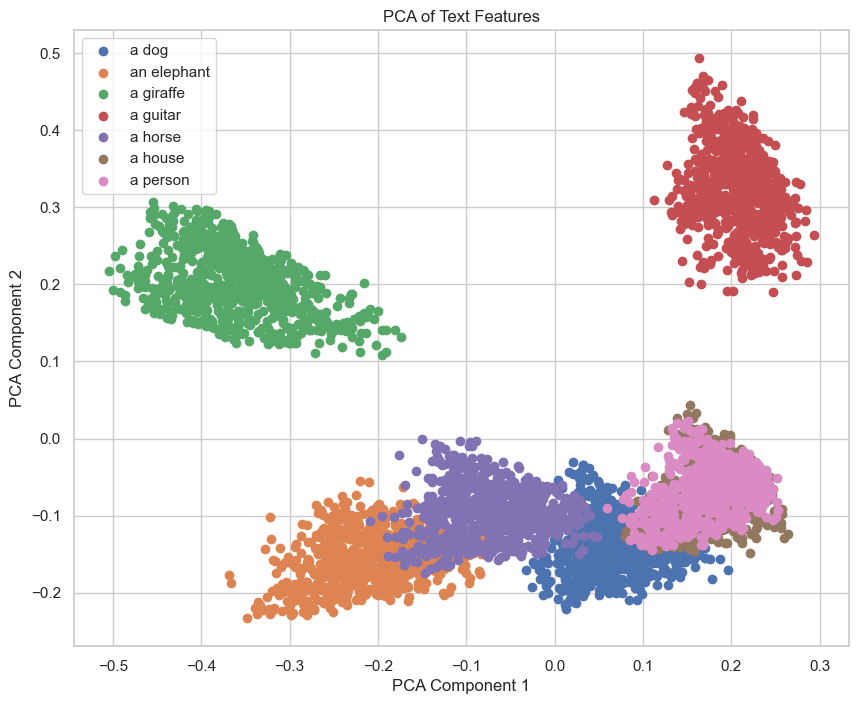

In [28]:
# PCA 
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
pca.fit(np.concatenate([tf.numpy() for (key, tf) in text_features.items()], axis=0))

# plot PCA on same figure
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

colors = sns.color_palette("deep", len(classes))
i = 0
for cls, tf in text_features.items():
    pca_result = pca.transform(tf.numpy())
    plt.scatter(pca_result[:, 0], pca_result[:, 1], label=cls, color=colors[i])
    i += 1

plt.title("PCA of Text Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [32]:
import itertools
import random
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch import optim

class Adapter(nn.Module):
    def __init__(self, dim, hidden_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, dim),
        )
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.norm(x + self.net(x))

# ------------------ Feature Triplet Dataset ------------------
class FeatureTripletDataset(Dataset):
    """
    Constructs triplets (anchor, positive, negative) from text_features.
    text_features: dict[class_key -> Tensor(num_domains, dim)] or list of Tensors.
    """
    def __init__(self, text_features):
        if isinstance(text_features, dict):
            self.class_keys = list(text_features.keys())
            self.features = [text_features[k] for k in self.class_keys]
        else:
            self.features = text_features
            self.class_keys = list(range(len(self.features)))
        # convert all features to CPU float tensors
        self.features = [feat.detach().cpu().float() for feat in self.features]
        self.lengths = [feat.size(0) for feat in self.features]
        self.num_classes = len(self.features)
        if self.num_classes < 2:
            raise ValueError("Need at least 2 classes for triplet generation")

    def __len__(self):
        # define epoch length as total possible anchors
        return sum(self.lengths)

    def __getitem__(self, idx):  # idx ignored for random sampling
        # Sample a class with at least 2 samples
        cls = random.choice([c for c, l in enumerate(self.lengths) if l >= 2])
        n_samples = self.lengths[cls]
        a_idx, p_idx = random.sample(range(n_samples), 2)
        anchor = self.features[cls][a_idx]
        positive = self.features[cls][p_idx]

        # Sample negative class and sample
        neg_cls = random.choice([c for c in range(self.num_classes) if c != cls])
        neg_idx = random.randrange(self.lengths[neg_cls])
        negative = self.features[neg_cls][neg_idx]

        return anchor, positive, negative

# ------------------ Triplet Training ------------------

def cosine_dist(x, y):
    # returns 1 − cosine_similarity, so smaller means more similar
    return 1.0 - F.cosine_similarity(x, y, dim=1)


def train_adapter(
    text_features, device='cuda',
    lr=1e-3, batch_size=128, epochs=20,
    num_workers=0
):
    """
    Train an Adapter using triplet loss on precomputed text_features.

    Args:
        text_features: dict or list of Tensor(num_domains, dim)
        device: 'cuda' or 'cpu'
        lr: learning rate
        batch_size: batch size
        epochs: number of epochs
        num_workers: DataLoader worker count (0 for debug)

    Returns:
        Trained Adapter model
    """
    dataset = FeatureTripletDataset(text_features)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=(device=='cuda'),
    )

    # infer feature dimension
    sample_feat = next(iter(dataset))[0]
    dim = sample_feat.size(0)

    adapter = Adapter(dim).to(device)
    loss_fn = nn.TripletMarginWithDistanceLoss(
        margin=0.2, distance_function=cosine_dist, reduction='mean')
    optimizer = optim.Adam(adapter.parameters(), lr=lr)

    adapter.train()
    for epoch in range(1, epochs+1):
        total_loss = 0.0
        for anchor, positive, negative in tqdm(loader, desc=f"Epoch {epoch}"):
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            out_a = adapter(anchor)
            out_p = adapter(positive)
            out_n = adapter(negative)

            loss = loss_fn(out_a, out_p, out_n)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch} — avg loss: {avg_loss:.4f}")

    return adapter

# Example usage:
# adapter = train_adapter(text_features_dict, device='cuda', num_workers=0)


adapter = train_adapter(text_features, device='cuda')


Epoch 1: 100%|██████████| 42/42 [00:00<00:00, 48.82it/s]


Epoch 1 — avg loss: 0.0056


Epoch 2: 100%|██████████| 42/42 [00:00<00:00, 97.74it/s] 


Epoch 2 — avg loss: 0.0000


Epoch 3: 100%|██████████| 42/42 [00:00<00:00, 101.89it/s]


Epoch 3 — avg loss: 0.0000


Epoch 4: 100%|██████████| 42/42 [00:00<00:00, 100.04it/s]


Epoch 4 — avg loss: 0.0000


Epoch 5: 100%|██████████| 42/42 [00:00<00:00, 102.75it/s]


Epoch 5 — avg loss: 0.0000


Epoch 6: 100%|██████████| 42/42 [00:00<00:00, 97.58it/s]


Epoch 6 — avg loss: 0.0000


Epoch 7: 100%|██████████| 42/42 [00:00<00:00, 100.04it/s]


Epoch 7 — avg loss: 0.0000


Epoch 8: 100%|██████████| 42/42 [00:00<00:00, 104.71it/s]


Epoch 8 — avg loss: 0.0000


Epoch 9: 100%|██████████| 42/42 [00:00<00:00, 104.50it/s]


Epoch 9 — avg loss: 0.0000


Epoch 10: 100%|██████████| 42/42 [00:00<00:00, 103.06it/s]


Epoch 10 — avg loss: 0.0000


Epoch 11: 100%|██████████| 42/42 [00:00<00:00, 96.40it/s] 


Epoch 11 — avg loss: 0.0000


Epoch 12: 100%|██████████| 42/42 [00:00<00:00, 103.67it/s]


Epoch 12 — avg loss: 0.0000


Epoch 13: 100%|██████████| 42/42 [00:00<00:00, 103.24it/s]


Epoch 13 — avg loss: 0.0000


Epoch 14: 100%|██████████| 42/42 [00:00<00:00, 102.17it/s]


Epoch 14 — avg loss: 0.0000


Epoch 15: 100%|██████████| 42/42 [00:00<00:00, 104.50it/s]


Epoch 15 — avg loss: 0.0000


Epoch 16: 100%|██████████| 42/42 [00:00<00:00, 100.04it/s]


Epoch 16 — avg loss: 0.0000


Epoch 17: 100%|██████████| 42/42 [00:00<00:00, 108.22it/s]


Epoch 17 — avg loss: 0.0000


Epoch 18: 100%|██████████| 42/42 [00:00<00:00, 106.89it/s]


Epoch 18 — avg loss: 0.0000


Epoch 19: 100%|██████████| 42/42 [00:00<00:00, 107.59it/s]


Epoch 19 — avg loss: 0.0000


Epoch 20: 100%|██████████| 42/42 [00:00<00:00, 107.54it/s]

Epoch 20 — avg loss: 0.0000


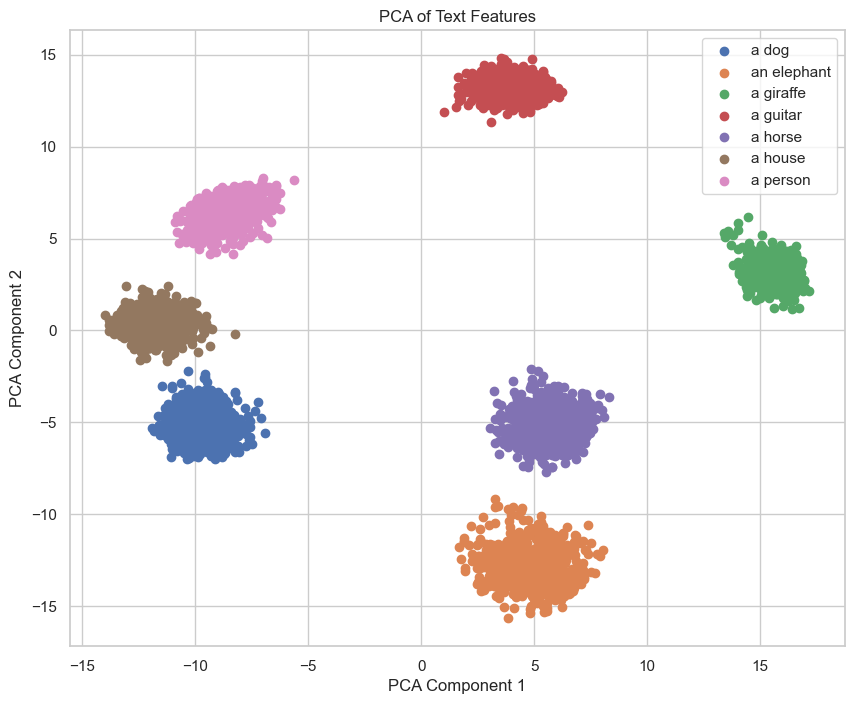

In [39]:
# PCA 
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

adapted_features = {cls: None for cls in classes}
for cls in classes:
    # Apply adapter to each class
    with torch.no_grad():
        adapted_features[cls] = adapter(text_features[cls].to(device)).cpu()

pca = PCA(n_components=2)

pca.fit(np.concatenate([tf.numpy() for (key, tf) in adapted_features.items()], axis=0))

# plot PCA on same figure
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

colors = sns.color_palette("deep", len(classes))
i = 0
for cls, tf in adapted_features.items():
    pca_result = pca.transform(tf.numpy())
    plt.scatter(pca_result[:, 0], pca_result[:, 1], label=cls, color=colors[i])
    i += 1

plt.title("PCA of Text Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

# PACS data

In [50]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

def evaluate_clip_prompts(
    image_feats: torch.Tensor,    # (N, D), precomputed
    image_labels: torch.Tensor,   # (N,), integer labels 0..C-1
    model,
    processor,
    classes: list            # list of class strings, e.g. ['a dog', ...]
):
    """
    Evaluates CLIP zero-shot using 'a photo of {class}' prompts for each class.
    Returns accuracy, auc per class vs rest, confusion matrix, and classification report.
    """
    device = next(model.parameters()).device
    # prepare text prompts
    prompts = [f"a photo of {cls.replace('a ', '').replace('an ', '')}" for cls in classes]
    text_inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_feats = model.get_text_features(**text_inputs)  # (C, D)
        text_feats = text_feats / text_feats.norm(dim=1, keepdim=True)
        # image_feats may already be normalized; ensure floats on device
        feats = image_feats.to(device).float()              # (N, D)
        feats = feats / feats.norm(dim=1, keepdim=True)

        logit_scale = model.logit_scale.exp()
        logits = logit_scale * feats @ text_feats.t()      # (N, C)
        probs = logits.softmax(dim=1)
        preds = logits.argmax(dim=1)

    y_true = image_labels.cpu().numpy()
    y_pred = preds.cpu().numpy()

    # compute metrics
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=classes, digits=4)
    # For multi-class AUC, compute one-vs-rest
    try:
        auc = roc_auc_score(
            y_true, probs.cpu().numpy(), multi_class='ovr'
        )
    except Exception:
        auc = None
    return {'accuracy': acc, 'auc': auc, 'cm': cm, 'report': report}


def evaluate_clip_with_adapter(
    image_feats: torch.Tensor,
    image_labels: torch.Tensor,
    model,
    processor,
    adapter,
    classes: list
):
    """
    Same as evaluate_clip_prompts, but applies adapter to both text and image features.
    """
    device = next(model.parameters()).device
    prompts = [f"a photo of {cls.replace('a ', '').replace('an ', '')}" for cls in classes]
    text_inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        # text side
        text_feats = model.get_text_features(**text_inputs)  # (C, D)
        text_feats = text_feats / text_feats.norm(dim=1, keepdim=True)
        text_feats = adapter(text_feats)
        text_feats = text_feats / text_feats.norm(dim=1, keepdim=True)

        # image side
        feats = image_feats.to(device).float()
        feats = feats / feats.norm(dim=1, keepdim=True)
        feats = adapter(feats)
        feats = feats / feats.norm(dim=1, keepdim=True)

        logit_scale = model.logit_scale.exp()
        logits = logit_scale * feats @ text_feats.t()      # (N, C)
        probs = logits.softmax(dim=1)
        preds = logits.argmax(dim=1)

    y_true = image_labels.cpu().numpy()
    y_pred = preds.cpu().numpy()

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=classes, digits=4)
    try:
        auc = roc_auc_score(
            y_true, probs.cpu().numpy(), multi_class='ovr'
        )
    except Exception:
        auc = None
    return {'accuracy': acc, 'auc': auc, 'cm': cm, 'report': report}

In [ ]:
import deeplake

print("=== Loading PACS Dataset ===")
ds = deeplake.load("hub://activeloop/pacs-test")

In [60]:
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from tqdm import tqdm


print("=== Loading Images ===")
loader = ds.pytorch(
    batch_size=128,
    shuffle=False,
    num_workers=0,
    # Specify decoding images as PIL objects
    decode_method={'images': 'pil'},
    # Keep transforms=None or only specify for other tensors if needed
    transforms={'labels': None, 'domains': None}, # Or simply remove if only images/labels/domains are loaded
)

print("Precomputing Image Features...")
all_feats = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(loader, desc="Processing Batches"):
        # use the correct keys
        images = batch["images"]      # PIL.Image list of length B
        labels = batch["labels"]      # torch.Tensor of shape (B,)

        # CLIP preprocessing + feature extraction
        inputs = processor(images=images, return_tensors="pt").to(device)
        feats = model.get_image_features(**inputs)      # (B, D)
        feats = feats / feats.norm(dim=-1, keepdim=True)

        all_feats.append(feats.cpu())
        all_labels.append(labels.cpu())

# Stack into single tensors
image_feats  = torch.cat(all_feats,  dim=0)  # (N, D)
image_labels = torch.cat(all_labels, dim=0)  # (N,)

# 3) Evaluate CLIP zero-shot (no adapter)
results_no_adapter = evaluate_clip_prompts(
    image_feats=image_feats,
    image_labels=image_labels,
    model=model,
    processor=processor,
    classes=classes
)

print("=== Zero-Shot CLIP (no adapter) ===")
print(f"Accuracy: {results_no_adapter['accuracy']:.4f}")
print(f"AUC (OvR): {results_no_adapter['auc']:.4f}")
print("Confusion Matrix:\n", results_no_adapter['cm'])
print("Classification Report:\n", results_no_adapter['report'])

# 4) Evaluate with Adapter
adapter = adapter.to(device)
results_with_adapter = evaluate_clip_with_adapter(
    image_feats=image_feats,
    image_labels=image_labels,
    model=model,
    processor=processor,
    adapter=adapter,
    classes=classes
)

print("\n=== Zero-Shot CLIP + Adapter ===")
print(f"Accuracy: {results_with_adapter['accuracy']:.4f}")
print(f"AUC (OvR): {results_with_adapter['auc']:.4f}")
print("Confusion Matrix:\n", results_with_adapter['cm'])
print("Classification Report:\n", results_with_adapter['report'])


=== Loading PACS Dataset ===


/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/pacs-test



/

hub://activeloop/pacs-test loaded successfully.



=== Loading Images ===
Precomputing Image Features...


Processing Batches:   0%|          | 0/79 [00:57<?, ?it/s]


KeyboardInterrupt: 